# Lab Notebook 06.17.2022

## Monosome Profiling variant analysis

### Goals
Given a ribosome profiling for untreated (UNT), TGF$\beta$ induced (TGF), and TGF$\beta$ induced with subsequent CX-5461 treatment (CX),

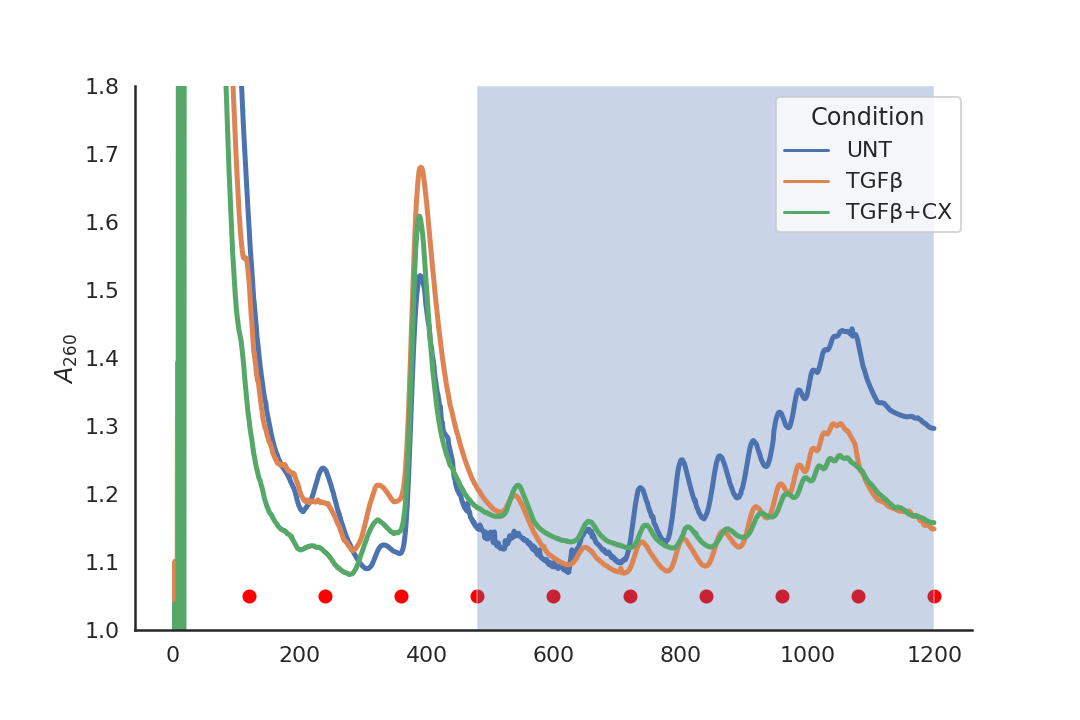

In [1]:
from IPython.display import Image
i=Image(filename="Updated_polysome_profiling_figure.png")
display(i)

our goal is to look at 
1. Perform a variant analysis on the monosomes, which consists of the largets shown peak between the 3rd and 4th red dots (fraction 4)
2. Compare the polysomal population (fractions 5-10) to the monosomes and check the differences. This will solidify what is happening in the translational pool vs those not translating.

### Hypothesis

1. There are no variants that exist that are specific to monosomes between UNT, TGF$\beta$, and CX conditions
2. Variants that exist in the ribosomal populations exist in the polysome pool, not the monosome pool.

### Note:
The current base path is `/research/groups/blancgrp/home/nmishra`. All following file paths will be written relative from wherever this base ends up.

## Viewing the Sequences on IGV

Our first objective will be to analyze the sequences on IGV. For this, I will be converting the bam files to bigwig format for ease of viewing on IGV. Our bam files are located in `.../ribo_seq/monosome_rnaseq/bam/all_rRNA`. To convert to bigwig format, we first convert to bedgraph format:

```bash
for i in *.bam; do bedtools genomecov -ibam $i -split -bg > $i.bed; done

for i in *.bed; do cat $i | sort -k1,1 -k2,2n > tmp.bed && mv tmp.bed $i; done

for i in *.bed; do bedGraphToBigWig $i \
/research/groups/blancgrp/home/nmishra/ribo_seq/mouse_ref/all_RNA/all_RNA_cdhit.fa.fai $i.bw; done

rename "s/.bed.bw/.bw/g" *
```

Here are the results for 28s, 18s, and 5.8s. These seem consistent with the previous sequencing:

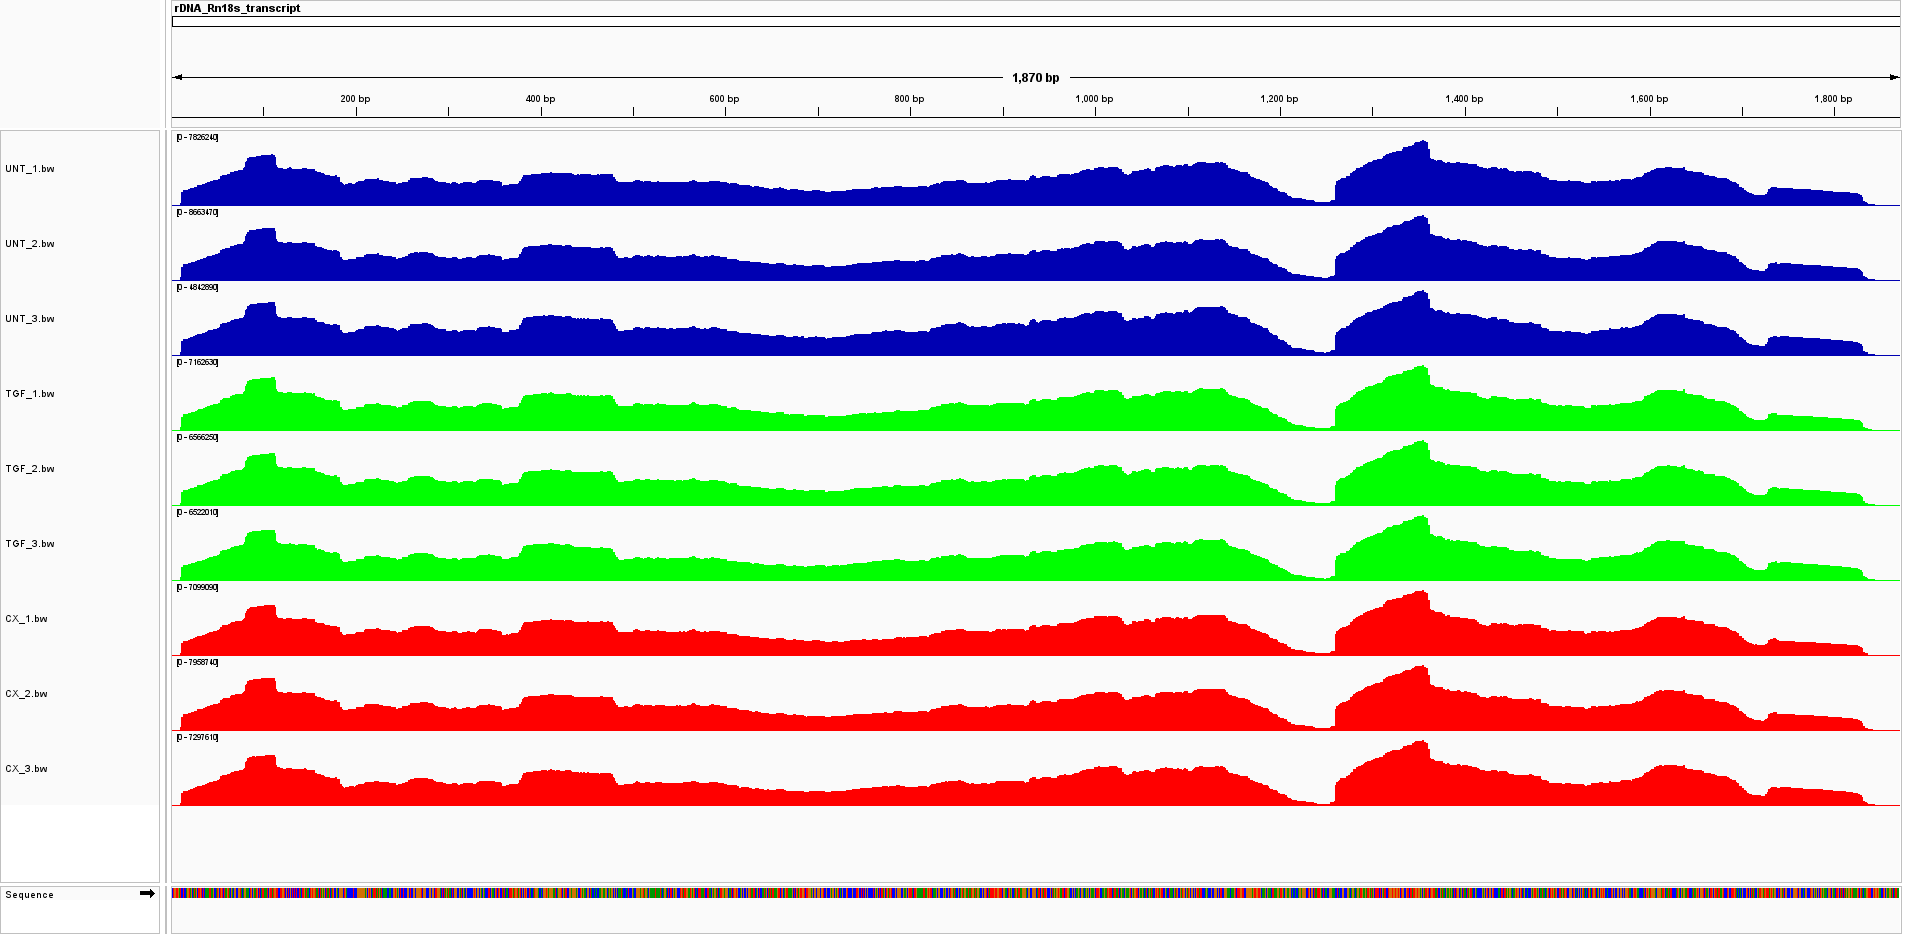

18s


In [5]:
i=Image(filename="Rn18s_igv.png")
display(i)
print("Above: 18s")

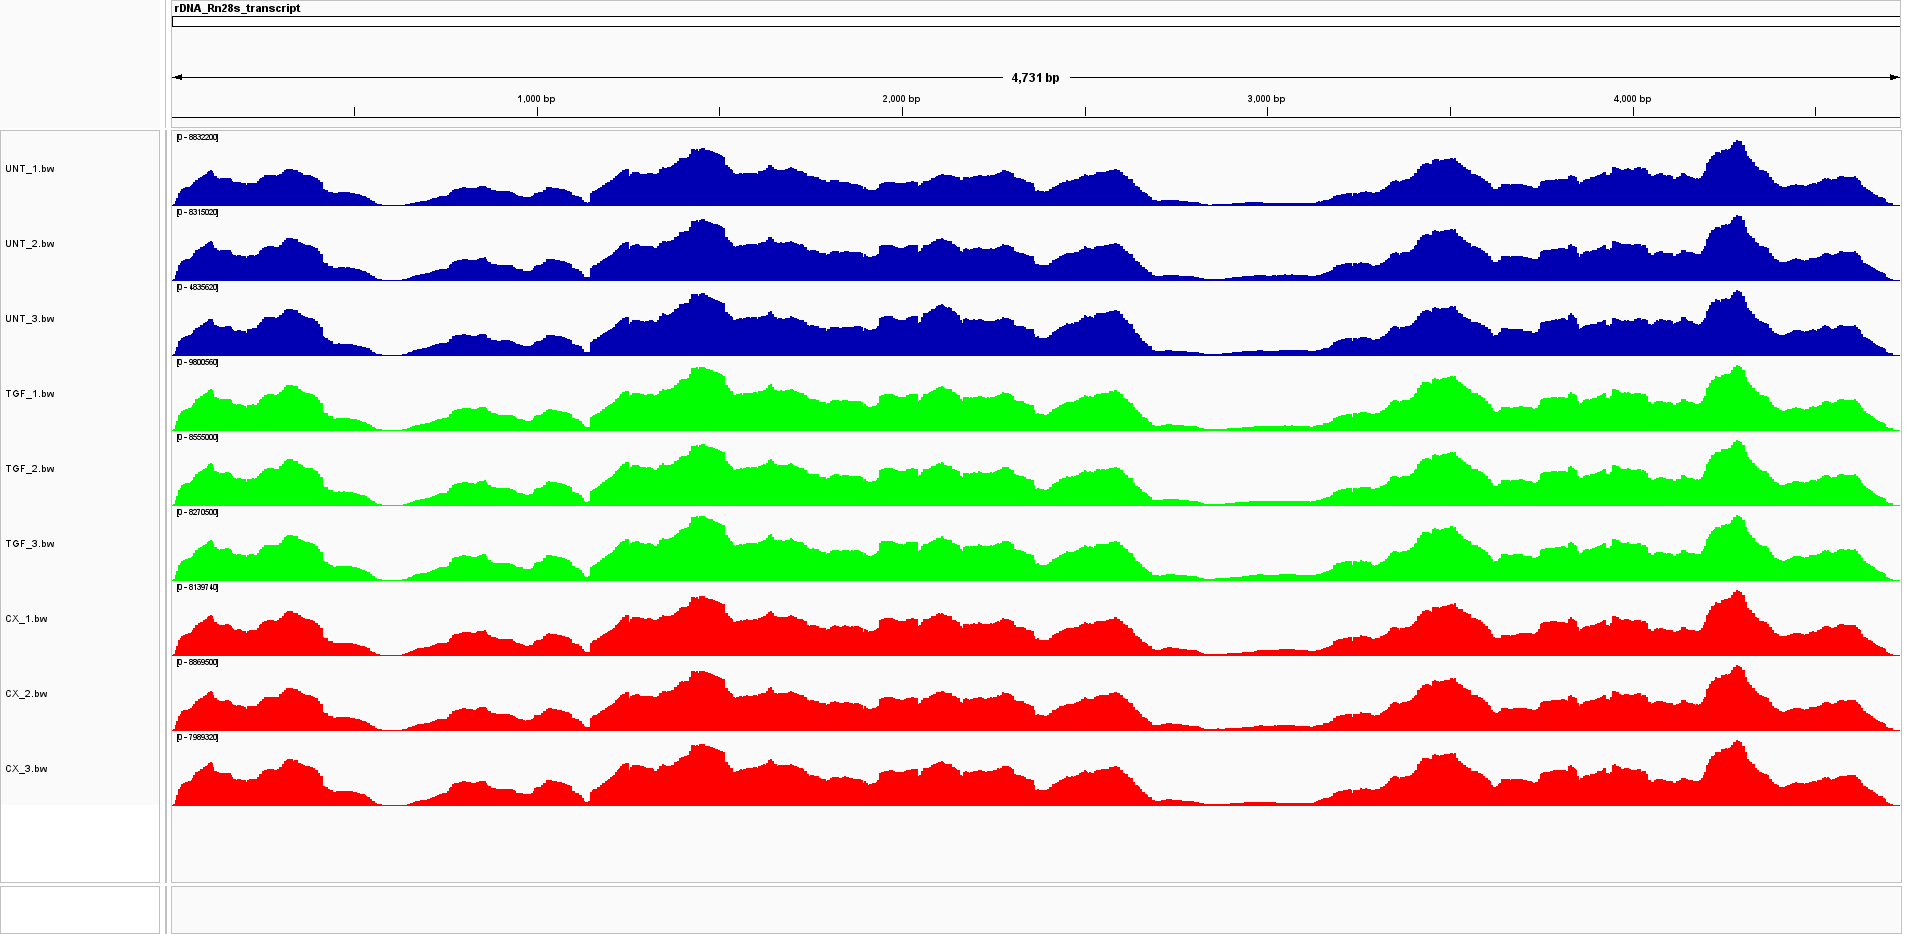

Above: 28s


In [7]:
i=Image(filename="Rn28s_igv.png")
display(i)
print("Above: 28s")

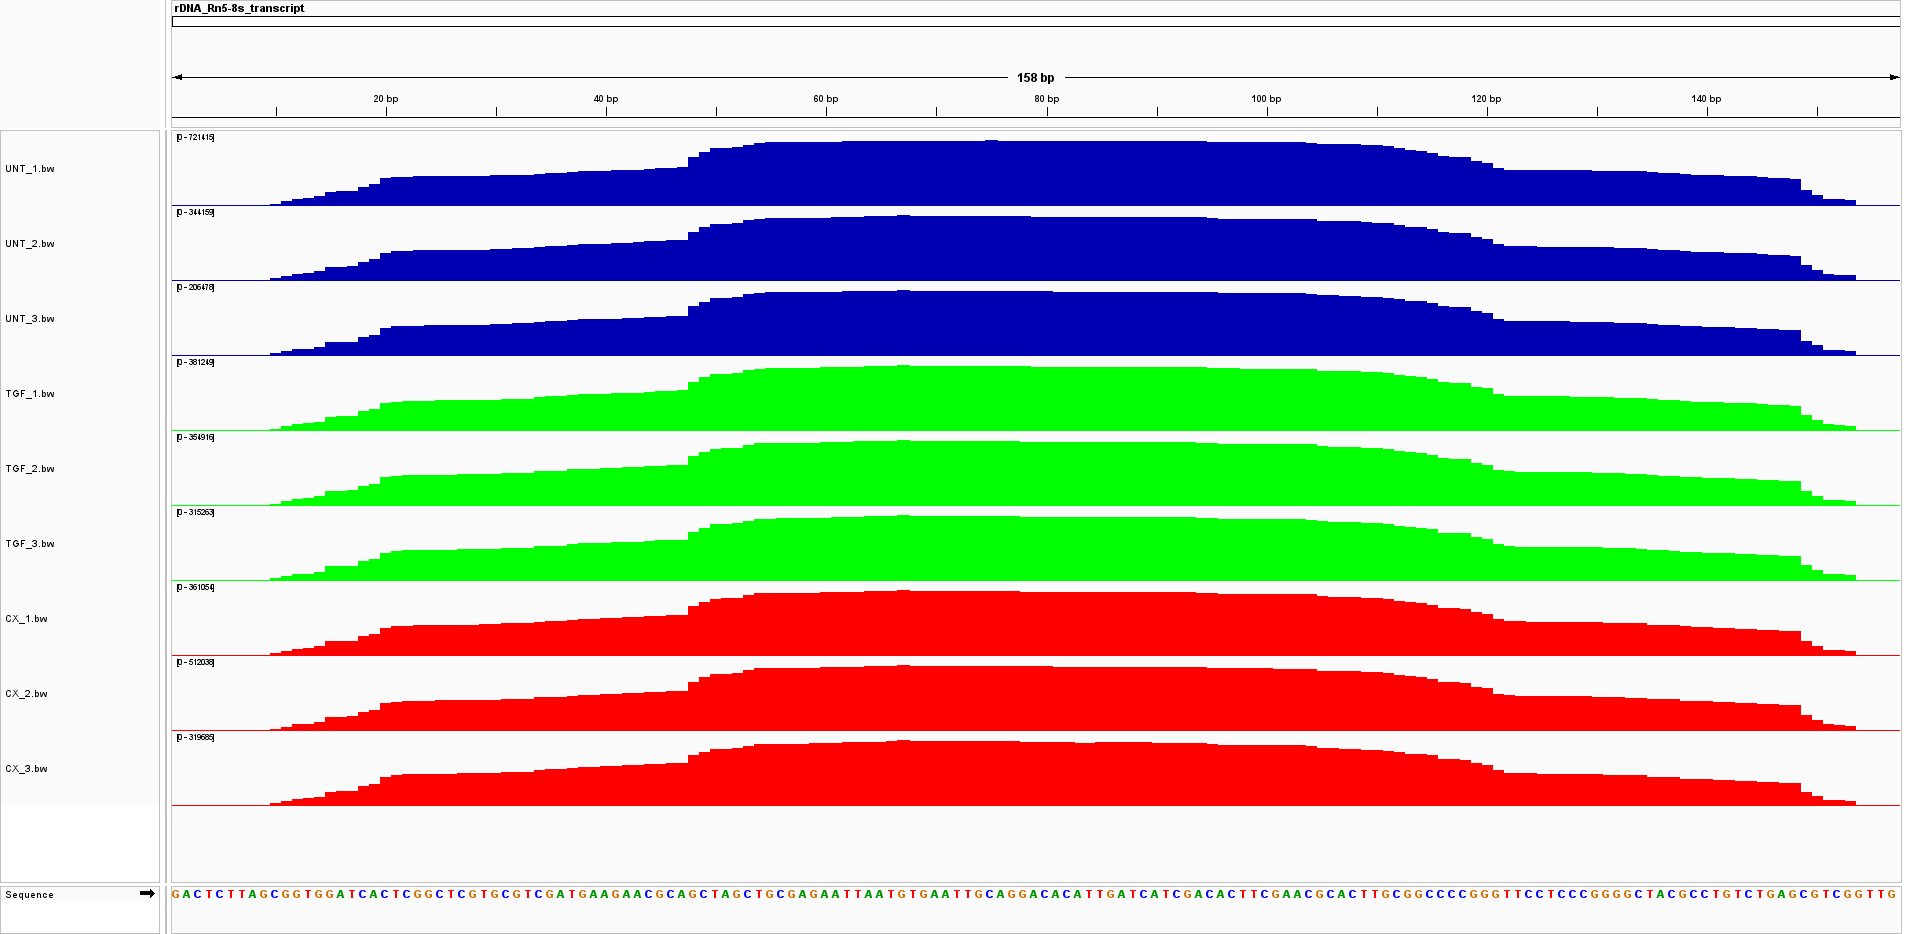

Above: 5.8s


In [6]:
i=Image(filename="Rn58s_igv.png")
display(i)
print("Above: 5.8s")

## Naive Variant Calling

As before, I wanted to first do a naive variant calling on the bam files using gatk's HaplotypeCaller. I created a folder in `.../ribo_seq/monosome_rnaseq/bam/all_rRNA/` titled `naive_variants` and `bcftools variants`. I then ran the script in this notebook called `naive_variants.sh`:

I am also going to run a naive bcftools caller.

This only looks at snps. Indels will be looked at if the HC picks up anything:

The resulting files above are located in `.../ribo_seq/monosome/rnaseq/bam/all_rRNA/variants` and the variants are in the files titled `<cond>_<rep>_variants.table`

## Variant Analysis

We will commence the analysis the same way we did in labnotebook04202022. See that notebook for full details. For now, I will just copy the code here and change the necessary variables.

I also created two folders in this labnotebook titled `polysome` and `monosome`. In the polysome folder there is the processed variants table, and in `monosome` there is currently the variant tables obtained from my `BQSR.sh` script.

In [10]:
import pandas as pd
import os
from max_utils import Variants



PATH = "/research/groups/blancgrp/home/nmishra/ribo_seq/monosome_rnaseq\
/bam/all_rRNA/variants/"
conds = ["UNT", "TGF", "CX"]


#first up - monosomes

mono_df = pd.DataFrame() #we will concatenate all the dataframes to this one.

for cond in conds:
    for reps in range(1,4):
       
        tmp_vars = pd.read_csv(os.path.join(PATH,f"{cond}_{reps}_variants.table"), sep = "\t")

        #Need to rename some columns to remove specific condition identifiers 
        #so that we can concatenate the dataframes
        tmp_vars = tmp_vars.rename(columns={f"{cond}.AD":"AD", f"{cond}.GT":"GT"})

        #Need to add a column describing this sample:
        tmp_vars["COND"] = f"{cond}_{reps}"

        mono_df = pd.concat([mono_df, tmp_vars])

mono_df = mono_df[mono_df.CHROM.isin(["rDNA_Rn18s_transcript",
                                     "rDNA_Rn28s_transcript",
                                     "rDNA_Rn5-8s_transcript"])]

#monosomes
mono_class = Variants(mono_df)
mono_class.calc_vaf()
mono_class.df.CHROM=mono_class.df.CHROM.str.replace("rDNA_Rn","").str.replace("_transcript","")

#pivot on POS
cx_cols = ["CX_1","CX_2","CX_3"]
tgf_cols =["TGF_1","TGF_2","TGF_3"]
unt_cols = ["UNT_1","UNT_2","UNT_3"]

mono_18 = mono_class.df[mono_class.df.CHROM == "18s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")


mono_58 = mono_class.df[mono_class.df.CHROM == "5-8s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")

mono_28 = mono_class.df[mono_class.df.CHROM == "28s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")
#after pivot, report means and standard deviations
#18s
mono_18.loc["CX_mean"] = mono_18.loc[cx_cols].mean()
mono_18.loc["TGF_mean"] = mono_18.loc[tgf_cols].mean()
mono_18.loc["UNT_mean"] = mono_18.loc[unt_cols].mean()

mono_18.loc["CX_sd"] = mono_18.loc[cx_cols].std()
mono_18.loc["TGF_sd"] = mono_18.loc[tgf_cols].std()
mono_18.loc["UNT_sd"] = mono_18.loc[unt_cols].std()

#28s
mono_28.loc["CX_mean"] = mono_28.loc[cx_cols].mean()
mono_28.loc["TGF_mean"] = mono_28.loc[tgf_cols].mean()
mono_28.loc["UNT_mean"] = mono_28.loc[unt_cols].mean()

mono_28.loc["CX_sd"] = mono_28.loc[cx_cols].std()
mono_28.loc["TGF_sd"] = mono_28.loc[tgf_cols].std()
mono_28.loc["UNT_sd"] = mono_28.loc[unt_cols].std()

#5.8s
mono_58.loc["CX_mean"] = mono_58.loc[cx_cols].mean()
mono_58.loc["TGF_mean"] = mono_58.loc[tgf_cols].mean()
mono_58.loc["UNT_mean"] = mono_58.loc[unt_cols].mean()

mono_58.loc["CX_sd"] = mono_58.loc[cx_cols].std()
mono_58.loc["TGF_sd"] = mono_58.loc[tgf_cols].std()
mono_58.loc["UNT_sd"] = mono_58.loc[unt_cols].std()

mono_class.df.to_csv("./monosome/mono_vaf.csv", header = True, index=False)

mono_18

POS,1,2,3,4,5,6,7,8,9,10,...,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870
COND,,,,,,,,,,,,,,,,,,,,,
CX_1,0.539249,0.426087,0.449749,0.448276,0.142636,0.062660,0.025090,0.017102,0.005233,0.006456,...,0.270548,0.265517,0.284722,0.299820,0.264493,0.285455,0.311355,0.292135,0.312741,0.307536
CX_2,0.552301,0.425249,0.420455,0.477901,0.075893,0.037284,0.007884,0.004857,0.005195,0.007113,...,0.270751,0.275794,0.313253,0.334711,0.304979,0.281837,0.338298,0.302174,0.320000,0.382629
CX_3,0.551724,0.358289,0.336364,0.488789,0.118519,0.069632,0.034483,0.018059,0.005805,0.007942,...,0.258065,0.256219,0.281407,0.280519,0.272727,0.274406,0.301075,0.269972,0.278552,0.337461
TGF_1,0.579710,0.479339,0.467128,0.535593,0.109756,0.059186,0.038505,0.011538,0.009978,0.011529,...,0.360684,0.370435,0.391228,0.405455,0.371115,0.388582,0.397004,0.384913,0.403614,0.404564
TGF_2,0.605263,0.449580,0.463768,0.449123,0.097127,0.046813,0.027422,0.015068,0.008170,0.011614,...,0.311419,0.321181,0.343310,0.342960,0.343636,0.349817,0.383333,0.336466,0.342967,0.418838
TGF_3,0.439189,0.331551,0.337719,0.445378,0.072034,0.029862,0.005829,0.003573,0.003025,0.004024,...,0.164865,0.184282,0.203857,0.212291,0.188034,0.177143,0.200000,0.226087,0.206997,0.258675
UNT_1,0.518160,0.424797,0.434555,0.410256,0.139752,0.076854,0.028789,0.017431,0.005486,0.009605,...,0.073883,0.081051,0.085043,0.086135,0.077599,0.093113,0.086568,0.085351,0.091506,0.104356
UNT_2,0.527273,0.396450,0.373711,0.456853,0.104978,0.052588,0.023358,0.016256,0.007135,0.011880,...,0.076333,0.081450,0.086563,0.089216,0.076822,0.085312,0.084108,0.085909,0.085607,0.104781
UNT_3,0.502463,0.352941,0.376667,0.464286,0.130742,0.083569,0.025641,0.012241,0.007282,0.005232,...,0.066843,0.063915,0.071141,0.078338,0.062586,0.070588,0.072575,0.067821,0.074460,0.083939


Now we do pvalues. For this, we will need the polysome data as well:

In [17]:
poly_class = pd.read_csv("./polysome/poly_vaf.csv",
                         index_col = None)
#pivot on POS
cx_cols = ["CX_1","CX_2","CX_3"]
tgf_cols =["TGF_1","TGF_2","TGF_3"]
unt_cols = ["UNT_1","UNT_2","UNT_3"]

poly_18 = poly_class[poly_class.CHROM == "18s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")


poly_58 = poly_class[poly_class.CHROM == "5-8s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")

poly_28 = poly_class[poly_class.CHROM == "28s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")
#after pivot, report means and standard deviations
#18s
poly_18.loc["CX_mean"] = poly_18.loc[cx_cols].mean()
poly_18.loc["TGF_mean"] = poly_18.loc[tgf_cols].mean()
poly_18.loc["UNT_mean"] = poly_18.loc[unt_cols].mean()

poly_18.loc["CX_sd"] = poly_18.loc[cx_cols].std()
poly_18.loc["TGF_sd"] = poly_18.loc[tgf_cols].std()
poly_18.loc["UNT_sd"] = poly_18.loc[unt_cols].std()

#28s
poly_28.loc["CX_mean"] = poly_28.loc[cx_cols].mean()
poly_28.loc["TGF_mean"] = poly_28.loc[tgf_cols].mean()
poly_28.loc["UNT_mean"] = poly_28.loc[unt_cols].mean()

poly_28.loc["CX_sd"] = poly_28.loc[cx_cols].std()
poly_28.loc["TGF_sd"] = poly_28.loc[tgf_cols].std()
poly_28.loc["UNT_sd"] = poly_28.loc[unt_cols].std()

#5.8s
poly_58.loc["CX_mean"] = poly_58.loc[cx_cols].mean()
poly_58.loc["TGF_mean"] = poly_58.loc[tgf_cols].mean()
poly_58.loc["UNT_mean"] = poly_58.loc[unt_cols].mean()

poly_58.loc["CX_sd"] = poly_58.loc[cx_cols].std()
poly_58.loc["TGF_sd"] = poly_58.loc[tgf_cols].std()
poly_58.loc["UNT_sd"] = poly_58.loc[unt_cols].std()

Looking at the pvalues between conditions within each sequencing type (i.e. monosome, polysome)

In [18]:
from scipy.stats import ttest_ind

conds = ["UNT", "TGF", "CX"]

#going to look at pvals between each condition separately for
#Polysome and mono controls.

poly_pvals = {}
mono_pvals = {}

for i in range(3):
    for j in range(i+1,3):
        _,pval = ttest_ind(poly_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248],
                           poly_18.loc[[f"{conds[j]}_{x}" 
                                        for x in range(1,4)], 1248])
        poly_pvals[f"{conds[i]}vs{conds[j]}"] = pval
        
        _,pval = ttest_ind(mono_18.loc[[f"{conds[i]}_{x}"
                                         for x in range(1,4)], 1248],
                           mono_18.loc[[f"{conds[j]}_{x}"
                                         for x in range(1,4)], 1248])
        mono_pvals[f"{conds[i]}vs{conds[j]}"] = pval
print("polysome pvals:")
for key,values in poly_pvals.items():
    print(key,":",values)
print("\nmono pvals:")
for key,values in mono_pvals.items():
    print(key,":",values)

polysome pvals:
UNTvsTGF : 0.013484657158315535
UNTvsCX : 0.0921490239078595
TGFvsCX : 0.00021847886839873143

mono pvals:
UNTvsTGF : 0.00214965823003932
UNTvsCX : 0.0016832373515952828
TGFvsCX : 0.5827388367883435


Now looking at differences between monosome seq and polysome seq within each condition

In [20]:
from scipy.stats import ttest_ind

conds = ["UNT", "TGF", "CX"]

#going to look at pvals between each condition separately for
#Polysome and monosome controls.

between_seqs_pvals = {}

for i in range(3):

    _,pval = ttest_ind(poly_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248],
                           mono_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248])
    between_seqs_pvals[f"{conds[i]}vs{conds[i]}"] = pval
        
print("between datasets pvals:")
for key,values in between_seqs_pvals.items():
    print(key,":",values)

between datasets pvals:
UNTvsUNT : 0.0826543532086298
TGFvsTGF : 0.28789934489288654
CXvsCX : 0.002184457778803949


Let's plot the above:

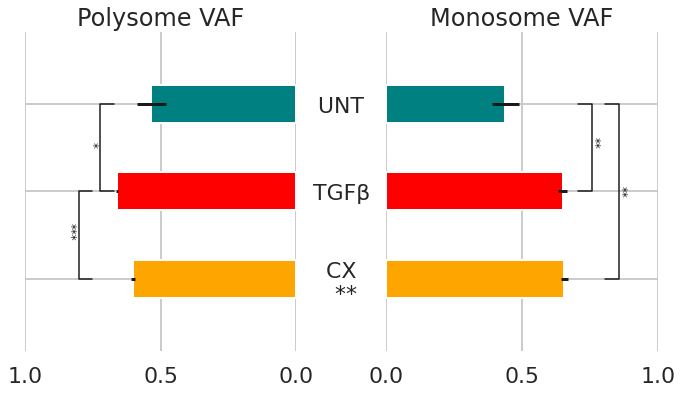

In [64]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sns.set("poster", style = "white")

#plt.style.use('ggplot')
colors=["teal","red","orange"]

samples = ["UNT ","TGFβ","CX  \n**  "]

poly_data = [poly_18.loc["UNT_mean",1248],
             poly_18.loc["TGF_mean",1248],
             poly_18.loc["CX_mean",1248]]

mono_data = [mono_18.loc["UNT_mean",1248],
             mono_18.loc["TGF_mean",1248],
             mono_18.loc["CX_mean",1248]]

poly_err = [poly_18.loc["UNT_sd",1248],
             poly_18.loc["TGF_sd",1248],
             poly_18.loc["CX_sd",1248]]

mono_err = [mono_18.loc["UNT_sd",1248],
             mono_18.loc["TGF_sd",1248],
             mono_18.loc["CX_sd",1248]]

y_range = np.arange(len(samples))[::-1]*1.15


fig,axes = plt.subplots(ncols=2,  figsize=(10,6))

axes[0].barh(y_range,poly_data, xerr = poly_err, align="center",
            color=colors, zorder=10, height = 0.5)
axes[0].set(title="Polysome VAF")
axes[0].set_xlim([0,1])
axes[0].set(yticks = y_range, yticklabels = [], xticks = [0,0.5,1])

axes[1].barh(y_range,mono_data, xerr = mono_err, align="center",
            color=colors, zorder=10, height = 0.5)
axes[1].set(title="Monosome VAF")
axes[1].set_xlim([0,1])

axes[0].invert_xaxis()
axes[1].set(yticks=y_range, yticklabels=samples, xticks = [0,0.5,1])
#axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.25)
    ax.grid(True)

    
#add significance bars
y1,y2,y3 = 0,1.15,2.3
x1, h, color = max(poly_data) + .09, .05, 'k'

axes[0].plot([x1, x1+h, x1+h, x1], [y1,y1,y2,y2], lw=1.5, c=color)
axes[0].text((x1+h+.03), (y1+y2)*.45, "***", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90)

x1 = max(poly_data) + .01
axes[0].plot([x1, x1+h, x1+h, x1], [y2,y2,y3,y3], lw=1.5, c=color)
axes[0].text((x1+h+.03), (y3+y2)*.5, "*", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90)

x1 = max(mono_data) + .05
axes[1].plot([x1, x1+h, x1+h, x1], [y2,y2,y3,y3], lw=1.5, c=color)
axes[1].text((x1+h+.01), (y3+y2)*.5, "**", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90)

x1 = max(mono_data) + .15
axes[1].plot([x1, x1+h, x1+h, x1], [y1,y1,y3,y3], lw=1.5, c=color)
axes[1].text((x1+h+.01), (y3+y2)*.31, "**", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90)


fig.tight_layout()
fig.subplots_adjust(wspace=0.33)
sns.despine(left=True, bottom = True)

fig.savefig("HC_18S.1248.png")

I also want to recapitulate this data with the bcftools method. We will do it like before in labnotebook04202022. 

We are going to index all of these files with GATK and then convert them into tab-delimited tables. Results are stored in 
`/research/groups/blancgrp/home/nmishra/ribo_seq/monosome_rnaseq/bam/all_rRNA/bcftools`:

```bash
for i in CX UNT TGF; do for j in 1 2 3; do gatk IndexFeatureFile -I ${i}_${j}.gvcf.gz;done;done

for i in CX UNT TGF; do
    for j in 1 2 3; do 
        gatk VariantsToTable -V ${i}_${j}.gvcf.gz \
        -F CHROM -F POS -F ID -F REF -F ALT -GF DP -GF AD \
        -O ${i}_${j}.bcftools_variants.table
    done
done

```

Let's remake the above figures with this new data:

In [73]:
import pandas as pd
import os
from max_utils import Variants

PATH = "/research/groups/blancgrp/home/nmishra/ribo_seq/monosome_rnaseq/bam/all_rRNA/"
conds = ["UNT", "TGF", "CX"]


#monosomes

mono_df = pd.DataFrame() #we will concatenate all the dataframes to this one.

for cond in conds:
    for reps in range(1,4):
       
        tmp_vars = pd.read_csv(os.path.join(PATH,"bcftools_variants",
                                            f"{cond}_{reps}.bcftools_variants.table"),
                               sep = "\t")

        #Need to rename some columns to remove specific condition identifiers 
        #so that we can concatenate the dataframes
        tmp_vars = tmp_vars.rename(columns={f"{PATH}{cond}_{reps}.bam.DP":"DP",
                                            f"{PATH}{cond}_{reps}.bam.AD":"AD"})

        #Need to add a column describing this sample:
        tmp_vars["COND"] = f"{cond}_{reps}"

        mono_df = pd.concat([mono_df, tmp_vars])

mono_df = mono_df[mono_df.CHROM.isin(["rDNA_Rn18s_transcript",
                                     "rDNA_Rn5-8s_transcript",
                                     "rDNA_Rn28s_transcript"])]

#load in polysome data
poly_class = pd.read_csv("./polysome/poly_bcftools_vaf.csv",
                         index_col=None)


#mono controls: determine VAF and process
mono_class = Variants(mono_df)
#mono_class.variant_type()
#mono_class.allelic_type()
mono_class.calc_vaf()
mono_class.df.CHROM=mono_class.df.CHROM.str.replace("rDNA_Rn","").str.replace("_transcript","")

#fille NAs with zeros in VAF mono:
mono_class.df.VAF = mono_class.df.VAF.fillna(0)

#pivot on POS
cx_cols = ["CX_1","CX_2","CX_3"]
tgf_cols =["TGF_1","TGF_2","TGF_3"]
unt_cols = ["UNT_1","UNT_2","UNT_3"]

poly_18 = poly_class[poly_class.CHROM == "18s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")

mono_18 = mono_class.df[mono_class.df.CHROM == "18s"].pivot(index="COND", 
                                                            columns="POS",
                                                            values="VAF")

poly_58 = poly_class[poly_class.CHROM == "5-8s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")

mono_58 = mono_class.df[mono_class.df.CHROM == "5-8s"].pivot(index="COND", 
                                                            columns="POS",
                                                            values="VAF")

poly_28 = poly_class[poly_class.CHROM == "28s"].pivot(index="COND", 
                                                          columns="POS",
                                                          values="VAF")

mono_28 = mono_class.df[mono_class.df.CHROM == "28s"].pivot(index="COND", 
                                                            columns="POS",
                                                            values="VAF")

#after pivot, report means and standard deviations
#18s
poly_18.loc["CX_mean"] = poly_18.loc[cx_cols].mean()
poly_18.loc["TGF_mean"] = poly_18.loc[tgf_cols].mean()
poly_18.loc["UNT_mean"] = poly_18.loc[unt_cols].mean()

mono_18.loc["CX_mean"] = mono_18.loc[cx_cols].mean()
mono_18.loc["TGF_mean"] = mono_18.loc[tgf_cols].mean()
mono_18.loc["UNT_mean"] = mono_18.loc[unt_cols].mean()

poly_18.loc["CX_sd"] = poly_18.loc[cx_cols].std()
poly_18.loc["TGF_sd"] = poly_18.loc[tgf_cols].std()
poly_18.loc["UNT_sd"] = poly_18.loc[unt_cols].std()

mono_18.loc["CX_sd"] = mono_18.loc[cx_cols].std()
mono_18.loc["TGF_sd"] = mono_18.loc[tgf_cols].std()
mono_18.loc["UNT_sd"] = mono_18.loc[unt_cols].std()

#28s
poly_28.loc["CX_mean"] = poly_28.loc[cx_cols].mean()
poly_28.loc["TGF_mean"] = poly_28.loc[tgf_cols].mean()
poly_28.loc["UNT_mean"] = poly_28.loc[unt_cols].mean()

mono_28.loc["CX_mean"] = mono_28.loc[cx_cols].mean()
mono_28.loc["TGF_mean"] = mono_28.loc[tgf_cols].mean()
mono_28.loc["UNT_mean"] = mono_28.loc[unt_cols].mean()

poly_28.loc["CX_sd"] = poly_28.loc[cx_cols].std()
poly_28.loc["TGF_sd"] = poly_28.loc[tgf_cols].std()
poly_28.loc["UNT_sd"] = poly_28.loc[unt_cols].std()

mono_28.loc["CX_sd"] = mono_28.loc[cx_cols].std()
mono_28.loc["TGF_sd"] = mono_28.loc[tgf_cols].std()
mono_28.loc["UNT_sd"] = mono_28.loc[unt_cols].std()

#5.8s
poly_58.loc["CX_mean"] = poly_58.loc[cx_cols].mean()
poly_58.loc["TGF_mean"] = poly_58.loc[tgf_cols].mean()
poly_58.loc["UNT_mean"] = poly_58.loc[unt_cols].mean()

mono_58.loc["CX_mean"] = mono_58.loc[cx_cols].mean()
mono_58.loc["TGF_mean"] = mono_58.loc[tgf_cols].mean()
mono_58.loc["UNT_mean"] = mono_58.loc[unt_cols].mean()

poly_58.loc["CX_sd"] = poly_58.loc[cx_cols].std()
poly_58.loc["TGF_sd"] = poly_58.loc[tgf_cols].std()
poly_58.loc["UNT_sd"] = poly_58.loc[unt_cols].std()

mono_58.loc["CX_sd"] = mono_58.loc[cx_cols].std()
mono_58.loc["TGF_sd"] = mono_58.loc[tgf_cols].std()
mono_58.loc["UNT_sd"] = mono_58.loc[unt_cols].std()

mono_class.df.to_csv("./monosome/mono_bcftools_vaf.csv", header = True, index=False)

mono_18

POS,1,2,3,4,5,6,7,8,9,10,...,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870
COND,,,,,,,,,,,,,,,,,,,,,
CX_1,0.0,0.0,0.0,0.109589,0.0,0.0,0.0,0.0,0.000192,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
CX_2,0.0,0.0,0.0,0.024096,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
CX_3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.004484,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
TGF_1,0.0,0.0,0.0,0.075000,0.0,0.0,0.0,0.0,0.000130,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
TGF_2,0.0,0.0,0.0,0.067797,0.0,0.0,0.0,0.0,0.000000,0.000156,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
TGF_3,0.0,0.0,0.0,0.019608,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
UNT_1,0.0,0.0,0.0,0.056604,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
UNT_2,0.0,0.0,0.0,0.024390,0.0,0.0,0.0,0.0,0.000000,0.000069,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
UNT_3,0.0,0.0,0.0,0.038462,0.0,0.0,0.0,0.0,0.000000,0.000107,...,0.0,0.0,0.000000,0.000841,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
from scipy.stats import ttest_ind

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


conds = ["UNT", "TGF", "CX"]

#going to look at pvals between each condition separately for
#Polysome and monosome.

poly_pvals = {}
mono_pvals = {}

for i in range(3):
    for j in range(i+1,3):
        _,pval = ttest_ind(poly_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248],
                           poly_18.loc[[f"{conds[j]}_{x}" 
                                        for x in range(1,4)], 1248])
        poly_pvals[f"{conds[i]}vs{conds[j]}"] = pval
        
        _,pval = ttest_ind(mono_18.loc[[f"{conds[i]}_{x}"
                                         for x in range(1,4)], 1248],
                           mono_18.loc[[f"{conds[j]}_{x}"
                                         for x in range(1,4)], 1248])
        mono_pvals[f"{conds[i]}vs{conds[j]}"] = pval
print("polysome pvals:")
for key,values in poly_pvals.items():
    print(key,":",values)
print("\nmono pvals:")
for key,values in mono_pvals.items():
    print(key,":",values)
    
#going to look at pvals between each condition separately for
#Polysome and monosome.

between_seqs_pvals = {}

for i in range(3):

    _,pval = ttest_ind(poly_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248],
                           mono_18.loc[[f"{conds[i]}_{x}" 
                                        for x in range(1,4)], 1248])
    between_seqs_pvals[f"{conds[i]}vs{conds[i]}"] = pval
        
print("between datasets pvals:")
for key,values in between_seqs_pvals.items():
    print(key,":",values)
    

polysome pvals:
UNTvsTGF : 0.0019162259088097372
UNTvsCX : 0.0050134732753946455
TGFvsCX : 0.003038565099323353

mono pvals:
UNTvsTGF : 1.270371101024424e-05
UNTvsCX : 3.0171957106330215e-05
TGFvsCX : 0.5234564209324577
between datasets pvals:
UNTvsUNT : 0.021026887237884612
TGFvsTGF : 0.22766092842384392
CXvsCX : 0.01514235090763098


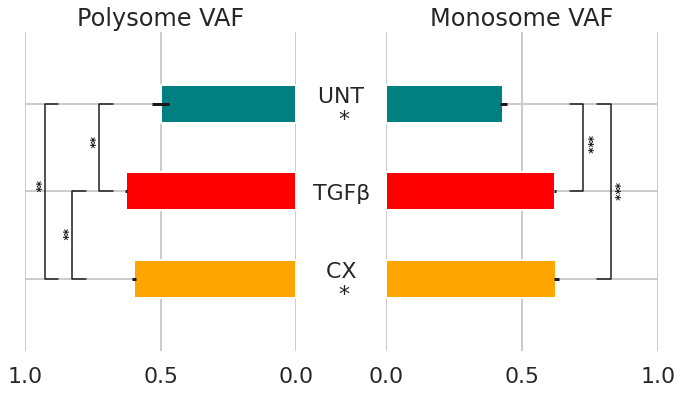

In [91]:
sns.set("poster", style = "white")

#plt.style.use('ggplot')
colors=["teal","red","orange"]

samples = [" UNT \n *   "," TGFβ","CX  \n *   "]

poly_data = [poly_18.loc["UNT_mean",1248],
             poly_18.loc["TGF_mean",1248],
             poly_18.loc["CX_mean",1248]]

mono_data = [mono_18.loc["UNT_mean",1248],
             mono_18.loc["TGF_mean",1248],
             mono_18.loc["CX_mean",1248]]

poly_err = [poly_18.loc["UNT_sd",1248],
             poly_18.loc["TGF_sd",1248],
             poly_18.loc["CX_sd",1248]]

mono_err = [mono_18.loc["UNT_sd",1248],
             mono_18.loc["TGF_sd",1248],
             mono_18.loc["CX_sd",1248]]

y_range = np.arange(len(samples))[::-1]*1.15


fig,axes = plt.subplots(ncols=2,  figsize=(10,6))

axes[0].barh(y_range,poly_data, xerr = poly_err, align="center",
            color=colors, zorder=10, height = 0.5)
            
axes[0].set(title="Polysome VAF")
axes[0].set_xlim([0,1])
axes[0].set(yticks = y_range, yticklabels = [], xticks = [0,0.5,1])

axes[1].barh(y_range,mono_data, xerr = mono_err, align="center",
            color=colors, zorder=10, height = 0.5)
axes[1].set(title="Monosome VAF")
axes[1].set_xlim([0,1])

axes[0].invert_xaxis()
axes[1].set(yticks=y_range, yticklabels=samples, xticks = [0,0.5,1])
#axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.25)
    ax.grid(True)

    
#add significance bars
y1,y2,y3 = 0,1.15,2.3
x1, h, color = max(poly_data) +.15, .05, 'k'

axes[0].plot([x1, x1+h, x1+h, x1], [y1,y1,y2,y2], lw=1.5, c=color)
axes[0].text((x1+h+.035), (y1+y2)*.45, "**", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90,
            fontweight='bold')

x1 = max(poly_data) + .05
axes[0].plot([x1, x1+h, x1+h, x1], [y2,y2,y3,y3], lw=1.5, c=color)
axes[0].text((x1+h+.035), (y3+y2)*.5, "**", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90,
            fontweight='bold')

x1 = max(poly_data) + .25
axes[0].plot([x1, x1+h, x1+h, x1], [y1,y1,y3,y3], lw=1.5, c=color)
axes[0].text((x1+h+.035), (y3+y1)*.5, "**", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90,
            fontweight='bold')


x1 = max(mono_data) + .05
axes[1].plot([x1, x1+h, x1+h, x1], [y2,y2,y3,y3], lw=1.5, c=color)
axes[1].text((x1+h+.015), (y3+y2)*.48, "***", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90,
            fontweight='bold')

x1 = max(mono_data) + .15
axes[1].plot([x1, x1+h, x1+h, x1], [y3,y3,y1,y1], lw=1.5, c=color)
axes[1].text((x1+h+.015), (y1+y3)*.45, "***", ha = "center",
         va = "bottom", color=color, fontsize = 12, rotation = -90,
            fontweight='bold')

fig.tight_layout()
fig.subplots_adjust(wspace=0.33)
sns.despine(left=True, bottom = True)

fig.savefig("bcftools_18S.1248.png")

## Searching for other variants in the monosome sequencing

We will apply the same steps and code used in labnotebook04202022. I don't want to write everything over again.

In [102]:
mono_18.loc["delta_TGF_UNT"] = mono_18.loc["TGF_mean"] - mono_18.loc["UNT_mean"]
mono_18.loc["delta_CX_TGF"] = mono_18.loc["CX_mean"] - mono_18.loc["TGF_mean"]

mono_28.loc["delta_TGF_UNT"] = mono_28.loc["TGF_mean"] - mono_28.loc["UNT_mean"]
mono_28.loc["delta_CX_TGF"] = mono_28.loc["CX_mean"] - mono_28.loc["TGF_mean"]

mono_18_10 = mono_18.loc[:,(np.abs(mono_18.loc["delta_TGF_UNT"]) >= 0.05) &
                                      (mono_18.loc["UNT_mean"] >= 0.05) &
                                      (mono_18.loc["TGF_mean"] >= 0.05)]
mono_28_10 = mono_28.loc[:,(np.abs(mono_28.loc["delta_TGF_UNT"]) >= 0.05) &
                                    (mono_28.loc["UNT_mean"] >= 0.05) &
                                    (mono_28.loc["TGF_mean"] >= 0.05)]

mono_18_10

POS,1248
COND,
CX_1,0.614640
CX_2,0.630681
CX_3,0.633537
TGF_1,0.624049
TGF_2,0.619359
TGF_3,0.622784
UNT_1,0.444518
UNT_2,0.419863
UNT_3,0.430103


In [103]:
mono_28_10

POS
COND
CX_1
CX_2
CX_3
TGF_1
TGF_2
TGF_3
UNT_1
UNT_2
UNT_3


As you can see from the above, there are no additional variants that we can see between the different conditions in the monosome sequencing

## Conclusions

1. There it is. Our results solidify the idea that in the translating pool (polysomes), there seems to be reversible hyper-methylation, while in the monosome pool and overall pool (see labnotebook04202022), there seems to be hypermethylation from UNT to TGF$\beta$ conditions with no reversibility with the addition of CX-5461.
2. There are no additional differences in the monosome pool.